Imports

In [29]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np

In [45]:

def get_funcs(b,c,max_speed):
    #Speed of leading car
    def v_f(c,t,omega,amplitude_local):
        return c+amplitude_local*np.cos(omega*t)

    #Defining the accelaration function by the PD controller
    def acc(d,v_self,v_front,T_local):
        return b*(v_front-v_self)+c*(d-v_front*T_local)

    #Defining adjusted accelaration function
    # c1 is the lower limit of the 'rate-zero'. 
    # c2 is the upper limit of the 'rate-zero'. 
    # c3 is the lower limit, where the acceleration becomes constant.
    # c4 is the upper limit, where the acceleration becomes constant.
    def acc_adj(a, v_self, c1, c2, c3, c4, k, l):
        g = (c4/2)*((max_speed-v_self)/max_speed)*(np.abs(np.tanh(l*a))+np.tanh(l*a))+(c3/2)*((max_speed+v_self)/max_speed)*(np.abs(np.tanh(l*a))-np.tanh(l*a))
        f = 1+ 1/2*(np.tanh(k * (g - c2)) - np.tanh(k * (g - c1)))
        z = f*g 
        return z
    return v_f,acc,acc_adj


def simulate_system(time_steps,time_period,b,c,omega,amplitude,max_speed, number_of_cars, position, velocity,constant_leading_speed, adjusted_acceleration, c1,c2,c3,c4,k,l):
    v_f,acc,acc_adj = get_funcs(b,c,max_speed)
    # time_steps = 100000
    # time_period = 120
    step_size = time_period/time_steps

    relative_position = []
    for i in range(number_of_cars-1):
        relative_position.append([])
        relative_position[i].append(position[i][0]-position[i+1][0])

    # Using eulers method
    for i in range(time_steps):
        for j in range(number_of_cars):
            position[j].append(position[j][i] + velocity[j][i]*step_size)
            if j != 0:
                relative_position[j-1].append(position[j-1][i] - position[j][i])
            if j == 0:
                velocity[j].append(v_f(constant_leading_speed,(i*step_size),omega,amplitude))
            else:
                if adjusted_acceleration:
                    a_temp = acc(relative_position[j-1][i],velocity[j][i],velocity[j-1][i],T)
                    a = acc_adj(a_temp, velocity[j][i], c1,c2,c3,c4,k,l)
                else:
                    a = acc(relative_position[j-1][i],velocity[j][i],velocity[j-1][i],T)
                velocity[j].append(velocity[j][i] + a*step_size)

    return step_size,time_steps,relative_position,acc_adj



def plot_system(step_size, time_steps, velocity, relative_position, number_of_cars,b,c,omega,T, x_range):
    # Create time array
    time = np.array([i * step_size for i in range(time_steps+1)])
    velocity = np.array(velocity)
    relative_position = np.array(relative_position)

    time_idxs1 = x_range[0]<time
    time_idxs2 = x_range[1]>time[time_idxs1]

    time = time[time_idxs1][time_idxs2]
    velocity =  velocity[:,time_idxs1][:,time_idxs2]
    relative_position = relative_position[:,time_idxs1][:,time_idxs2]

    # Plot velocities
    plt.figure(figsize=(10, 5))
    for i in range(number_of_cars):
        if i == 0:
            plt.plot(time, velocity[i], label="Lead Car")
        else:
            plt.plot(time, velocity[i], label="Car "+str(number_of_cars-i))
    plt.title(f"Velocity of Cars Over Time. b={b},c={c},w={omega},T={T}")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.legend()
    plt.grid(True)
    # plt.xlim(0, time_period+2) 
    plt.xlim(x_range[0], x_range[1]) 
    plt.ylim(min(min(row) for row in velocity)-0.1*max(max(row) for row in velocity), 1.1*max(max(row) for row in velocity))  

    plt.show()
    plt.show()

    # Plot relative distances
    plt.figure(figsize=(10, 5))
    for i in range(number_of_cars-1):
        if i == 0:
            plt.plot(time, relative_position[i], label="Distance from leading-Car to Car "+str(number_of_cars-1))
        else:
            plt.plot(time, relative_position[i], label="Distance from Car "+str(number_of_cars-i)+" to Car "+str(number_of_cars-i-1)) 
    plt.title(f"Relative Distances Between Cars Over Time. b={b},c={c},w={omega},T={T}")
    plt.xlabel("Time (s)")
    plt.ylabel("Relative Distance (m)")
    plt.legend()
    plt.grid(True)
    plt.xlim(x_range[0], x_range[1]) 
    # plt.xlim(0, time_period+2) 
    y_range = 0
    plt.ylim(min(min(row) for row in relative_position)-0.1*max(max(row) for row in relative_position), 1.1*max(max(row) for row in relative_position))  
    plt.show()


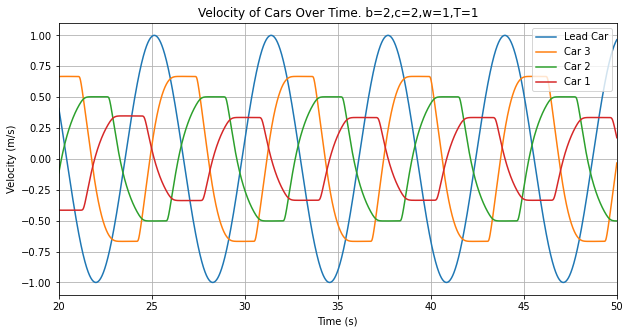

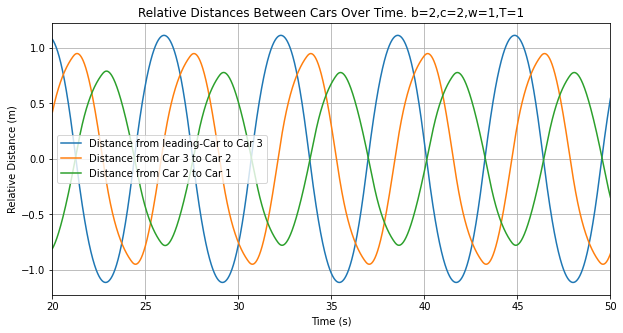

In [51]:
#Defining variables
# Define number of cars including the leader.
#number_of_cars = 2
constant_leading_speed,omega, amplitude = 0, 1, 1
number_of_cars = 4
b,c=2,2
T=1
# Defining constants for adjusted acceleration
c1,c2,c3,c4 = -1,1,-10,10
k,l = 10, 0.1
adjusted_acceleration = True 
max_speed = 50
# Defining starting positions
position = [[70*i] for i in range(number_of_cars-1,-1,-1)]
velocity = [[0] for i in range(number_of_cars)]

x_range = [20,50]
time_steps = int(1e5)
time_period = 50
step_size,time_steps,relative_position,acc_adj = simulate_system(time_steps,time_period,b,c,omega,amplitude,max_speed, number_of_cars, position, velocity,constant_leading_speed, adjusted_acceleration, c1,c2,c3,c4,k,l)

plot_system(step_size, time_steps, velocity, relative_position, number_of_cars,b,c,omega,T, x_range)


Plotting a_adjusted against a:

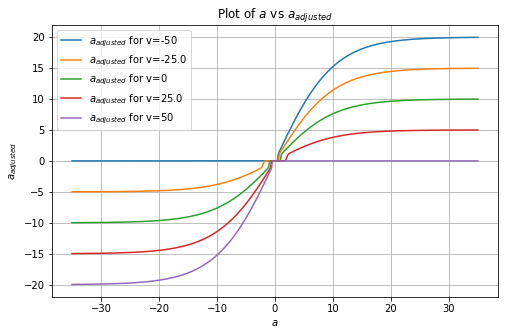

In [ ]:
# Generate data for a
a_values = np.linspace(-35, 35, 5000)
v = [-max_speed, -max_speed/2, 0, max_speed/2, max_speed]

# Plot
plt.figure(figsize=(8, 5))
for vel in v:
    a_adjusted = acc_adj(a_values, vel, c1, c2, c3, c4, k, l)
    plt.plot(a_values, a_adjusted, label=f'$a_{{adjusted}}$ for v={vel}')

# Additional plot details
plt.title('Plot of $a$ vs $a_{adjusted}$')
plt.xlabel('$a$')
plt.ylabel('$a_{adjusted}$')
plt.legend()
plt.grid(True)
plt.show()